In [1]:
import xarray as xr
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import argparse
import intake
from intake import open_catalog
from matplotlib import colors, cm, pyplot as plt

In [2]:
raw_data_address='/scratch/zanna/data/cm2.6/surf-data.zarr'

In [4]:
ds_data=xr.open_zarr(raw_data_address)

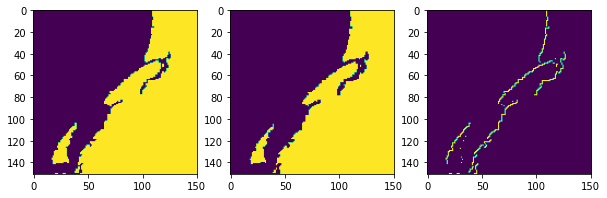

In [86]:
xmin,ymin=1450,1750
dx,dy=151,151
u=ds_data.isel(time=0,xu_ocean=slice(xmin,xmin+dx),yu_ocean=slice(ymin,ymin+dy)).usurf.values
T=ds_data.isel(time=0,xt_ocean=slice(xmin,xmin+dx),yt_ocean=slice(ymin,ymin+dy)).surface_temp.values
u[u==u]=0
u[u!=u]=1

T[T==T]=0
T[T!=T]=1


fig,axs=plt.subplots(1,3,figsize=(10,5))
axs[0].imshow(u)
axs[1].imshow(T)
axs[2].imshow(u-T)

In [79]:
from scipy import signal
from scipy import misc
corr = signal.correlate2d(u, T, boundary='fill', mode='same')

In [80]:
maxind = np.argwhere(corr == np.amax(corr)).flatten().tolist()

In [81]:
maxind

[75, 75]

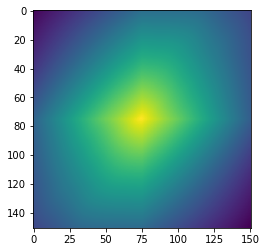

In [82]:
plt.imshow(corr)

In [133]:
xu=ds_data.xu_ocean.values
yu=ds_data.yu_ocean.values

xt=ds_data.xt_ocean.values
yt=ds_data.yt_ocean.values

In [134]:
dyu=yu[1:]-yu[:-1]
dxu=xu[1:]-xu[:-1]

In [90]:
i,j=100,100
di,dj=5,5

In [194]:
def turn_to_km(x,y):
    dyy=y[1:]-y[:-1]
    dxx=x[1]-x[0]
    R_earth=6371
    dlon=np.abs(R_earth*np.cos(y/180*np.pi)*dxx/180)
    dlat=R_earth*np.cos(y[1:]/180*np.pi)*dyy/180

    lon=np.cumsum(dlon)
    lat=np.cumsum(dlat)

    lon=np.concatenate([np.zeros(1,),lon],axis=0)
    lat=np.concatenate([np.zeros(1,),lat],axis=0)
    
    
    imin=np.argmin(np.abs(x))
    xx=np.zeros((len(y),len(x)))
    for i in range(len(y)):
        xx[i,:]=dlon[i]*np.arange(len(x))
    lon=(xx-xx[:,imin:imin+1]).reshape([-1,])
    lat=np.concatenate([lat.reshape([-1,1])]*len(x),axis=1).reshape([-1,])
    return lon, lat

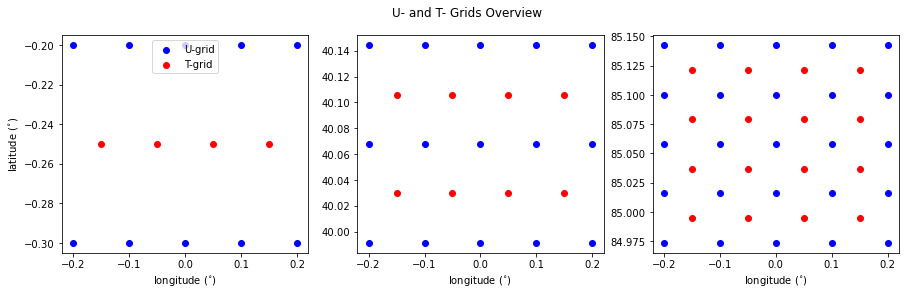

In [217]:
fig,axs=plt.subplots(1,3,figsize=(15,4))
fig.patch.set_facecolor('white')

ymins=[-0.3-0.01,40-0.01,85-0.05]
fig.suptitle('U- and T- Grids Overview')
for ii in range(len(ymins)):
    xmin=-0.25
    dx=0.55
    xmax=xmin+dx
    ymin=ymins[ii]
    dy=0.25
    ymax=ymin+dy

    i=np.where(xu>xmin)[0][0]
    di=np.where(xu<xmax)[0][-1]-i

    i=np.where(xu>xmin)[0][0]
    di=np.where(xu<xmax)[0][-1]-i

    j=np.where(yu>ymin)[0][0]
    dj=np.where(yu<ymax)[0][-1]-j


    x=xu[i:i+di]
    y=yu[j:j+dj]
     
#     xv_,yv_=turn_to_km(x,y)
    
    xv, yv = np.meshgrid(x, y, indexing='ij')
    xv=xv.reshape([-1,])
    yv=yv.reshape([-1,])


    x=(x[1:]+x[:-1])/2
    y=(y[1:]+y[:-1])/2

    xvt, yvt = np.meshgrid(x, y, indexing='ij')
    xvt=xvt.reshape([-1,])
    yvt=yvt.reshape([-1,])
    
    
    
    ax=axs[ii]
    ax.scatter(xv,yv,color='b',label='U-grid')
    ax.scatter(xvt,yvt,color='r',label='T-grid')
    if ii==0:
        ax.legend(loc='upper center')
        ax.set_ylabel('latitude ($^{\circ}$)')
    ax.set_xlabel('longitude ($^{\circ}$)')
#     ax=axs[1,ii]
#     ax.scatter(xv_,yv_,color='b')
    
   

In [143]:
R_earth=6371
dlon=np.abs(R_earth*np.cos(yu[1:]/180*np.pi)*dxu[0]/180)
dlat=R_earth*np.cos(yu[1:]/180*np.pi)*dyu/180

In [158]:
lines=[dyu,dlat,dxu[0]*np.ones(dlon.shape),dlon]

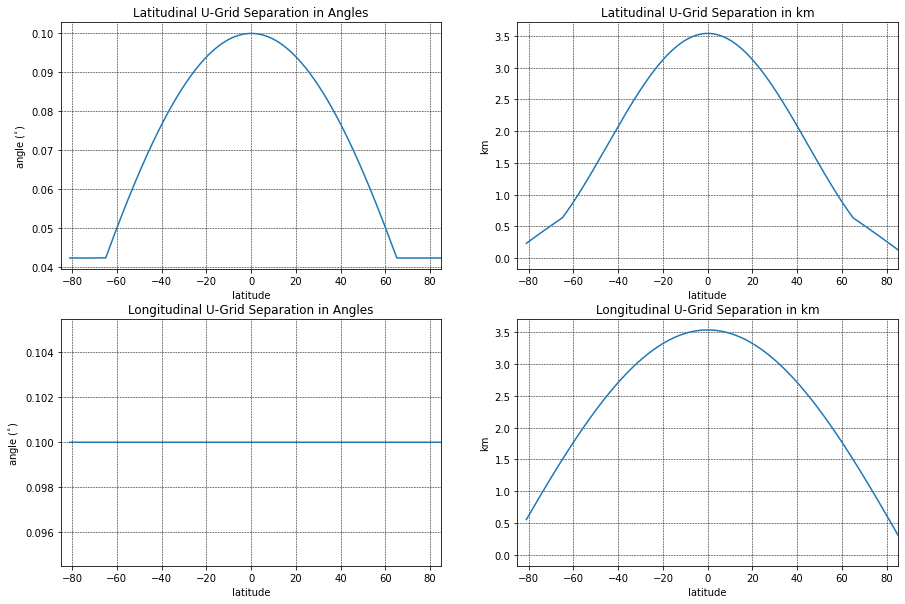

In [214]:
fig,axs=plt.subplots(2,2,figsize=(15,10))
fig.patch.set_facecolor('white')
titles=['Latitudinal U-Grid Separation in Angles','Latitudinal U-Grid Separation in km',\
              'Longitudinal U-Grid Separation in Angles','Longitudinal U-Grid Separation in km' ]
for i in range(4):
    i0=i//2
    i1=i%2
    ax=axs[i0,i1]
    ax.plot(yu[1:],lines[i])
    ax.set_xlim([-85,85])
    ax.grid(linestyle='--', linewidth='0.5', color='k')
    if i1==0:
        ax.set_ylabel('angle ($^{\circ}$)')
    else:
         ax.set_ylabel('km')
    
    ax.set_xlabel('latitude')
    ax.set_title(titles[i])